## Imports
- Sets up Keras Core backend to use Tensorflow.

In [15]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow" # needs to be imported before
import keras_core as keras
from keras_core import layers
from keras_core import ops
import shutil
from PIL import Image
import keras_cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reorganize Data
The data is organized under the faces folder with one subfolder per person.
```
faces
├── phoebe
│   ├── phoebe_left_angry_sunglasses_2.pgm
│   ├── phoebe_right_sad_sunglasses.pgm
│   ├── phoebe_straight_neutral_open_4.pgm
│   ├── phoebe_up_happy_open_2.pgm
│   ...
├── mitchell
│   ├── mitchell_straight_happy_open_4.pgm
├── ...
```

In [2]:
os.mkdir("faces_dataset")
for direction in ["sunglasses", "open"]:
    os.mkdir(f"faces_dataset/{direction}")

FileExistsError: [Errno 17] File exists: 'faces_dataset'

In [300]:
for person_folder in os.listdir("faces"):
    if not person_folder.startswith("."):
        for image_filename in os.listdir(os.path.join("faces", person_folder)):
            tags = image_filename[:-4].split("_")
            if len(tags) == 4:
                label = tags[3] # direction face is pointing towards
                origin_path = os.path.join("faces", person_folder, image_filename)
                new_image_filename = "{}.png".format(image_filename[:-4])
                destination_path = os.path.join("faces_dataset", label, new_image_filename)
                if image_filename[-4:] == ".pgm":
                    with Image.open(origin_path) as im:
                        im.save(destination_path)

In [4]:
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    directory='faces_dataset/',
    labels="inferred",
    label_mode='categorical',
    batch_size=32,
    image_size=(64, 64),
    validation_split=0.2,
    subset="both",
    seed=0
)

Found 624 files belonging to 2 classes.
Using 500 files for training.
Using 124 files for validation.


In [5]:
def plot_image_grid(images, grid=3, title=None):
    fig, axes = plt.subplots(grid,grid, figsize=(grid*2,grid*2))
    for i in range(grid):
        for j in range(grid):
            if i*grid + j < len(images):
                axes[i][j].imshow(images[i*grid + j].astype('uint8'))
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    
X = np.concatenate([x for x, y in train_dataset], axis=0)
plot_image_grid(X, title="he")

NameError: name 'plt' is not defined

## Build Classification Model
    - You have a `tf.data.Dataset` dataset

In [6]:
model = keras.Sequential([
    keras.Input(shape=(256, 256, 3)),
    keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)      │        448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 16)      │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 16)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 2)                 │         34 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,442 (29.07 KB)

 Trainable params: 7,442 (29.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(5e-4),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)

In [8]:
# Should be able to get around 70% on validation
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
)

Epoch 1/30
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5828 - loss: 4.7807

2023-10-24 10:43:52.234889: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5384 - loss: 4.0113 - val_accuracy: 0.5645 - val_loss: 1.3474
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5146 - loss: 1.3831 - val_accuracy: 0.6532 - val_loss: 0.7629
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5641 - loss: 0.8687 - val_accuracy: 0.6694 - val_loss: 0.6278
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6266 - loss: 0.7163 - val_accuracy: 0.6452 - val_loss: 0.6036
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6471 - loss: 0.6490 - val_accuracy: 0.6855 - val_loss: 0.5809
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6600 - loss: 0.6068 - val_accuracy: 0.7258 - val_loss: 0.5405
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7034 - loss: 0.5651 - val_accuracy: 0.7177 - val_loss: 0.5060
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7523 - loss: 0.5254 - val_accuracy: 0.6774 - val_loss: 0.

In [9]:
history_df = pd.DataFrame(history.history)
history_df.head(3)

,accuracy,loss,val_accuracy,val_loss
0,0.512,3.153293,0.564516,1.347402
1,0.534,1.151730,0.653226,0.762935
2,0.562,0.826536,0.669355,0.627838


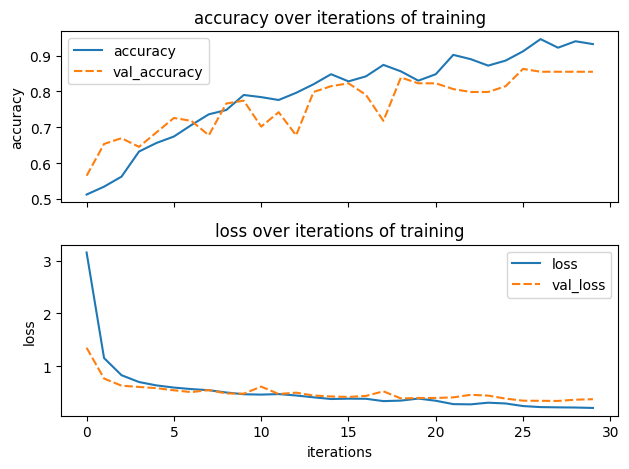

In [13]:
# Helper function to plot accuracy and loss of the run
def plot_history(history_df):
    fig, axes = plt.subplots(2,1, sharex=True)
    sns.lineplot(data=history_df[["accuracy", "val_accuracy"]], ax=axes[0]).set(
        title="accuracy over iterations of training",
        xlabel="iterations",
        ylabel="accuracy"
    )
    sns.lineplot(data=history_df[["loss", "val_loss"]], ax=axes[1]).set(
        title="loss over iterations of training",
        xlabel="iterations",
        ylabel="loss"
    )
    plt.tight_layout()
plot_history(history_df)

## Analyze the Model

In [14]:
model.evaluate(validation_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8971 - loss: 0.3123 


[0.3715427815914154, 0.8548387289047241]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


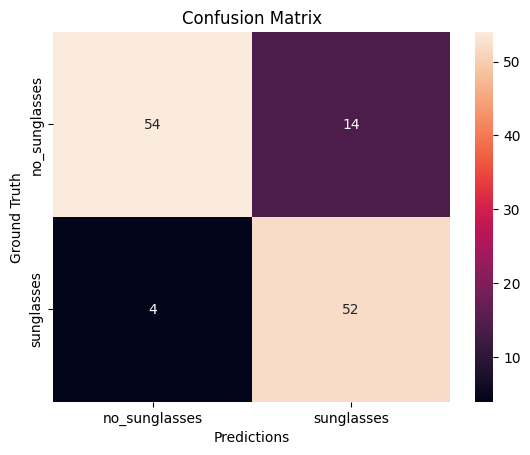

In [23]:
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)))
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            matrix[i][j] = np.count_nonzero((y_true == label_true) & (y_pred == label_pred))
    return matrix
        
def get_confusion_matrix(model, dataset):
    y_true = np.argmax(np.concatenate([y for x, y in dataset], axis=0), axis=1)
    y_pred = np.argmax(model.predict(dataset), axis=1)
    confusion_mat = confusion_matrix(y_true, y_pred)
    confusion_df = pd.DataFrame(
        confusion_mat, 
        columns=["no_sunglasses", "sunglasses"], 
        index=["no_sunglasses", "sunglasses"]
    )
    sns.heatmap(confusion_df, annot=True).set(
        title="Confusion Matrix",
        xlabel="Predictions",
        ylabel="Ground Truth"
    )
get_confusion_matrix(model, validation_dataset)

In [24]:
y_true = np.argmax(np.concatenate([y for x, y in validation_dataset], axis=0), axis=1)
X = np.concatenate([x for x, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)
predictions = list(zip(X, y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [25]:
# predicted sunglasses but no sunglasses
predictions1 = [image for image, y_true, y_pred in predictions if y_true == 0 and y_pred == 1]

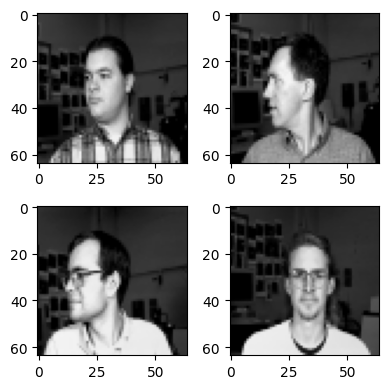

In [29]:
plot_image_grid(predictions1, grid=2)

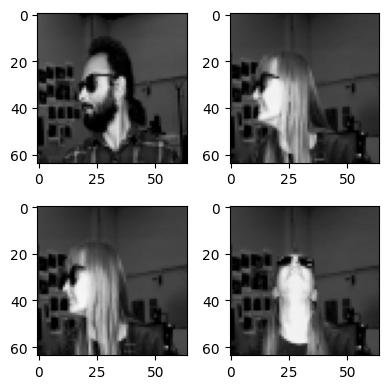

In [30]:
# predicted no sunglasses but sunglasses
predictions2 = [image for image, y_true, y_pred in predictions if y_true == 1 and y_pred == 0]
plot_image_grid(predictions2, grid=2)